# Exemplo de separação regional residual utilizando um ajuste polinomial robusto (Beltrão et al., 1998)

* Beltrão, J. F., Silva, J. B. C., and Costa, J. C. Robust polynomial fitting method for regional gravity estimation
    GEOPHYSICS, 56(1), 80-89. [doi: 10.1190/1.1442960](http://dx.doi.org/10.1190/1.1442960)

Este código utiliza a biblioteca de modelagem e inversão de dados geofísicos denominada [Fatiando a Terra](http://www.fatiando.org/index.html).

### Coisas para importar

In [1]:
%matplotlib inline
import numpy as np
from fatiando import mesher, gridder, utils
from fatiando.gravmag import sphere
from fatiando.vis import mpl

/home/vanderlei/Documents/fatiando/fatiando/vis/mpl.py:70: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
import matplotlib.pyplot as plt

### Pontos onde são calculados os dados

In [3]:
shape = (100, 100) # número de pontos ao longo de x e y
N = shape[0]*shape[1] # número de pontos
area = (-5000, 5000, -5000, 5000) # x mínimo, x máximo, y mínimo e y máximo da área
xp, yp, zp = gridder.regular(area, shape, z=-100) # grade regular localizada em z = -100 m

xc = 0.5*(area[1] + area[0]) # coordenadas x do centro da área
yc = 0.5*(area[3] + area[2]) # coordenadas y do centro da área

### Modelo de corpos esféricos

In [4]:
model = [mesher.Sphere(2000., -2000., 700., 500., {'density': 2000.}),
         mesher.Sphere(0., 2000., 700., 500., {'density': 3000.}),
         mesher.Sphere(-2000., -2000., 700., 1000., {'density': 500.})]

### Componente vertical da atração gravitational (em mGal)

In [5]:
c0 = -30.0
c1 = -0.0007
c2 = 0.0004
c3 = 0.0000001
c4 = 0.0000001
gz_esfera = sphere.gz(xp, yp, zp, model) # mGal
gz = c0 + c1*(xp - xc) + c2*(yp - yc) + c3*(xp - xc)**2 + c4*(yp - yc)**2 + gz_esfera

### Plot dos dados

/home/vanderlei/anaconda3/envs/fatiando2/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'picker'
  s)


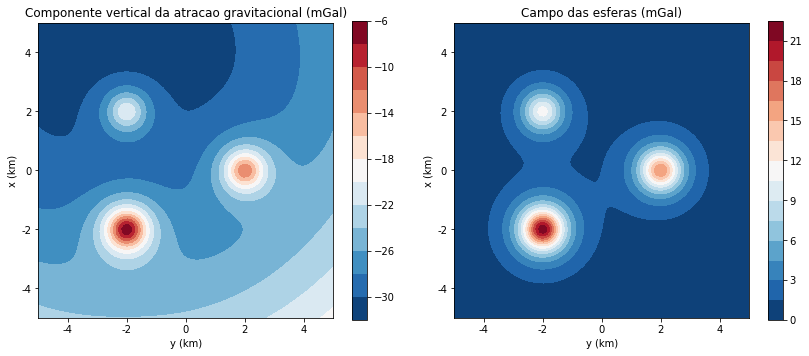

In [6]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title("Componente vertical da atracao gravitacional (mGal)")
plt.axis('scaled')
mpl.contourf(yp, xp, gz, shape, 15, cmap = plt.get_cmap('RdBu_r'))
plt.colorbar()
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

plt.subplot(1,2,2)
plt.title("Campo das esferas (mGal)")
plt.axis('scaled')
mpl.contourf(yp, xp, gz_esfera, shape, 15, cmap = plt.get_cmap('RdBu_r'))
plt.colorbar()
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

plt.tight_layout(pad = 2.)

plt.show()

### Ajuste polinomial simples

In [7]:
A = np.vstack((np.ones(N), xp, yp, xp**2., yp**2.)).T

In [8]:
p1 = np.linalg.solve(np.dot(A.T,A),np.dot(A.T,gz))

In [9]:
print '           c            p'
print '%12.5e %12.5e' % (c0,p1[0])
print '%12.5e %12.5e' % (c1,p1[1])
print '%12.5e %12.5e' % (c2,p1[2])
print '%12.5e %12.5e' % (c3,p1[3])
print '%12.5e %12.5e' % (c4,p1[4])

           c            p
-3.00000e+01 -2.65627e+01
-7.00000e-04 -7.76698e-04
 4.00000e-04  2.86568e-04
 1.00000e-07 -2.28463e-08
 1.00000e-07  8.30142e-09


In [10]:
gz_regional1 = np.dot(A,p1)

In [11]:
gz_residual1 = gz - gz_regional1

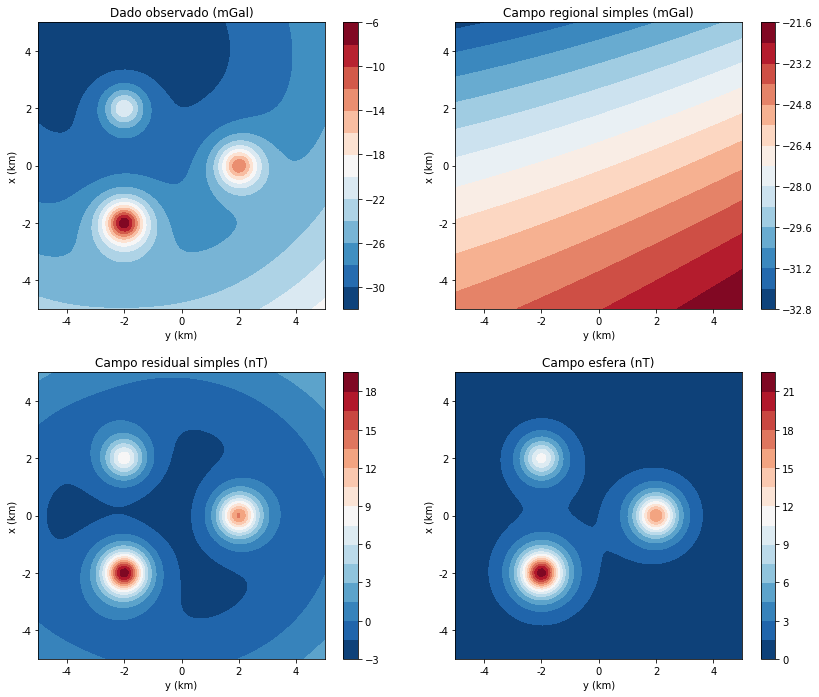

In [12]:
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.title("Dado observado (mGal)")
plt.axis('scaled')
mpl.contourf(yp, xp, gz, shape, 15, cmap = plt.get_cmap('RdBu_r'))
plt.colorbar()
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

plt.subplot(2,2,2)
plt.title("Campo regional simples (mGal)")
plt.axis('scaled')
mpl.contourf(yp, xp, gz_regional1, shape, 15, cmap = plt.get_cmap('RdBu_r'))
plt.colorbar()
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

plt.subplot(2,2,3)
plt.title("Campo residual simples (nT)")
plt.axis('scaled')
mpl.contourf(yp, xp, gz_residual1, shape, 15, cmap = plt.get_cmap('RdBu_r'))
plt.colorbar()
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

plt.subplot(2,2,4)
plt.title("Campo esfera (nT)")
plt.axis('scaled')
mpl.contourf(yp, xp, gz_esfera, shape, 15, cmap = plt.get_cmap('RdBu_r'))
plt.colorbar()
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

plt.tight_layout(pad = 2.)

plt.show()

### Ajuste polinomial robusto

In [13]:
iteracoes = 30

p2 = p1.copy()
gz_regional2 = gz_regional1.copy()

for i in range(iteracoes):
    r = gz - gz_regional2
    s = np.median(r)
    #W = np.diag(np.exp(-((0.6745*r/s)**2.)))
    W = np.diag(1./np.abs(r + 1.e-10))
    W = np.dot(A.T,W)
    p2 = np.linalg.solve(np.dot(W,A), np.dot(W,gz))
    gz_regional2 = np.dot(A, p2)

In [14]:
print '           c            p'
print '%12.5e %12.5e' % (c0,p2[0])
print '%12.5e %12.5e' % (c1,p2[1])
print '%12.5e %12.5e' % (c2,p2[2])
print '%12.5e %12.5e' % (c3,p2[3])
print '%12.5e %12.5e' % (c4,p2[4])

           c            p
-3.00000e+01 -2.82682e+01
-7.00000e-04 -7.28068e-04
 4.00000e-04  3.29368e-04
 1.00000e-07  4.26528e-08
 1.00000e-07  5.81963e-08


In [15]:
gz_residual2 = gz - gz_regional2

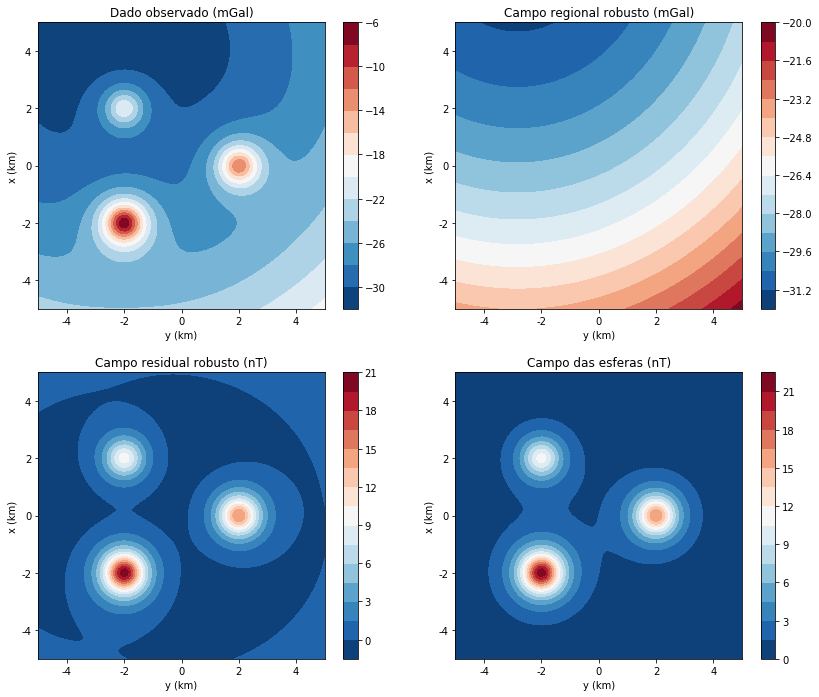

In [16]:
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.title("Dado observado (mGal)")
plt.axis('scaled')
mpl.contourf(yp, xp, gz, shape, 15, cmap = plt.get_cmap('RdBu_r'))
plt.colorbar()
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

plt.subplot(2,2,2)
plt.title("Campo regional robusto (mGal)")
plt.axis('scaled')
mpl.contourf(yp, xp, gz_regional2, shape, 15, cmap = plt.get_cmap('RdBu_r'))
plt.colorbar()
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

plt.subplot(2,2,3)
plt.title("Campo residual robusto (nT)")
plt.axis('scaled')
mpl.contourf(yp, xp, gz_residual2, shape, 15, cmap = plt.get_cmap('RdBu_r'))
plt.colorbar()
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

plt.subplot(2,2,4)
plt.title("Campo das esferas (nT)")
plt.axis('scaled')
mpl.contourf(yp, xp, gz_esfera, shape, 15, cmap = plt.get_cmap('RdBu_r'))
plt.colorbar()
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

plt.tight_layout(pad = 2.)

plt.show()

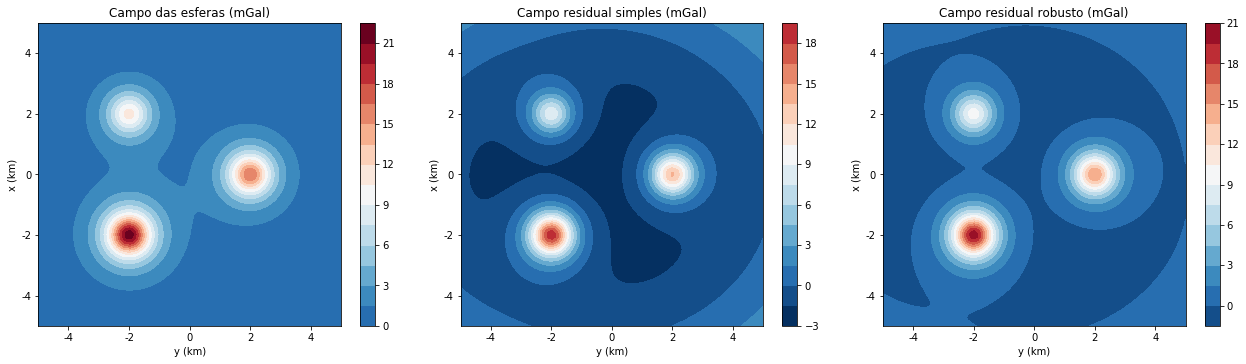

In [19]:
maximo = np.max([np.max(gz_esfera), np.max(gz_residual1), np.max(gz_residual2)])

minimo = np.min([np.min(gz_esfera), np.min(gz_residual1), np.min(gz_residual2)])

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.title("Campo das esferas (mGal)")
plt.axis('scaled')
mpl.contourf(yp, xp, gz_esfera, shape, 15, cmap = plt.get_cmap('RdBu_r'),
             vmin=minimo, vmax=maximo)
plt.colorbar()
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

plt.subplot(1,3,2)
plt.title("Campo residual simples (mGal)")
plt.axis('scaled')
mpl.contourf(yp, xp, gz_residual1, shape, 15, cmap = plt.get_cmap('RdBu_r'),
             vmin=minimo, vmax=maximo)
plt.colorbar()
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

plt.subplot(1,3,3)
plt.title("Campo residual robusto (mGal)")
plt.axis('scaled')
mpl.contourf(yp, xp, gz_residual2, shape, 15, cmap = plt.get_cmap('RdBu_r'),
             vmin=minimo, vmax=maximo)
plt.colorbar()
plt.xlabel('y (km)')
plt.ylabel('x (km)')
mpl.m2km()

plt.tight_layout(pad = 2.)

plt.show()